In [1]:
import loss
import numpy as np
import nyu
import scipy as sp
import scipy.io
import skimage
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rc('image', cmap='gray') # set default image colormap to gray

# try gaussian weighting of neighboring patches?

Found nyu_depth_v2_labeled.mat
Found splits.mat


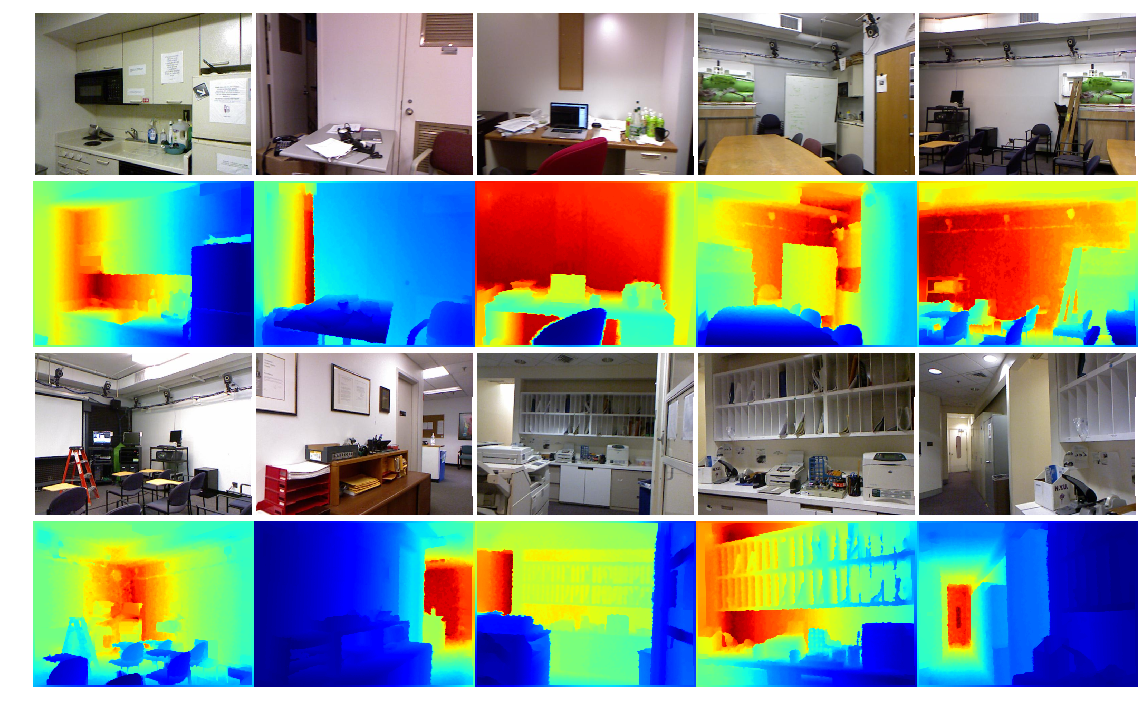

In [7]:
data, splits = nyu.get_data()
train_ids = splits['trainNdxs'].flatten() - 1
imgs = [np.transpose(data['images'][i], (2, 1, 0)) for i in train_ids[:10]]
depths = [nyu.get_depth(data['depths'], i) for i in train_ids[:10]]

f, ax = plt.subplots(4, 5, figsize=(16, 10))
[x.set_axis_off() for x in ax.ravel()]

for i in range(10):
    ax[(i // 5) * 2, i % 5].imshow(imgs[i])
    ax[(i // 5) * 2 + 1, i % 5].imshow(depths[i], cmap='jet')
plt.tight_layout()
f.subplots_adjust(hspace=0.0, wspace=0.0)

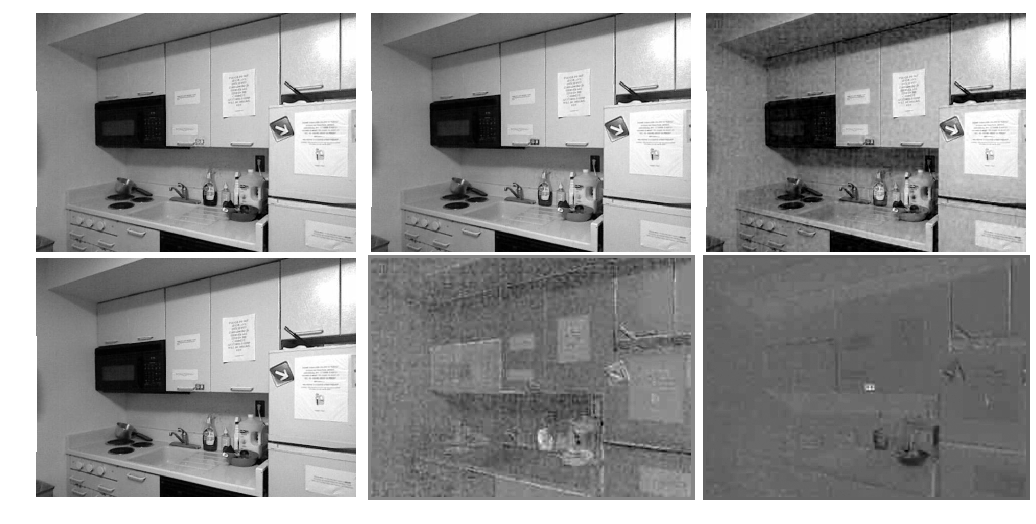

In [8]:
f, ax = plt.subplots(2, 3, figsize=(18, 9))
[x.set_axis_off() for x in ax.ravel()]
rgb = imgs[0]
ycbcr = skimage.color.rgb2ycbcr(imgs[0])
for i in range(3):
    ax[0, i].imshow(rgb[:, :, i])
    ax[1, i].imshow(ycbcr[:, :, i])
f.subplots_adjust(hspace=0.0, wspace=0.0)

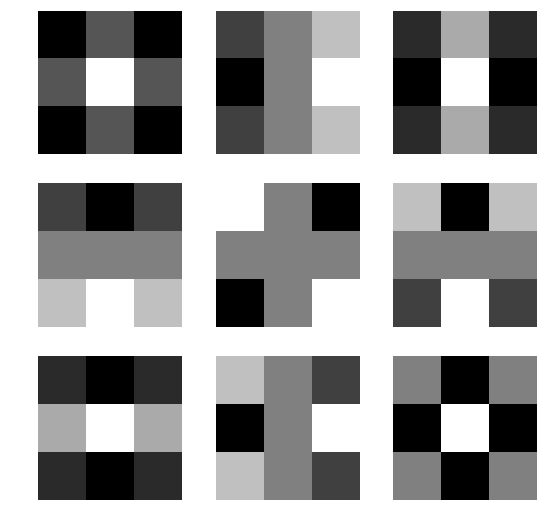

In [9]:
# 3x3 Laws filters from [Saxena et al. 2007]
L3 = np.array([1, 2, 1]) / 128 / .2
E3 = [-1, 0, 1]
S3 = [-1, 2, -1]

laws1d = [L3, E3, S3]
laws2d = []

for f1 in laws1d:
    for f2 in laws1d:
        laws2d.append(np.outer(f1, f2))

f, ax = plt.subplots(3, 3, figsize=(9, 9))
[x.set_axis_off() for x in ax.ravel()]

for i in range(len(laws2d)):
    ax[i // 3, i % 3].imshow(laws2d[i])

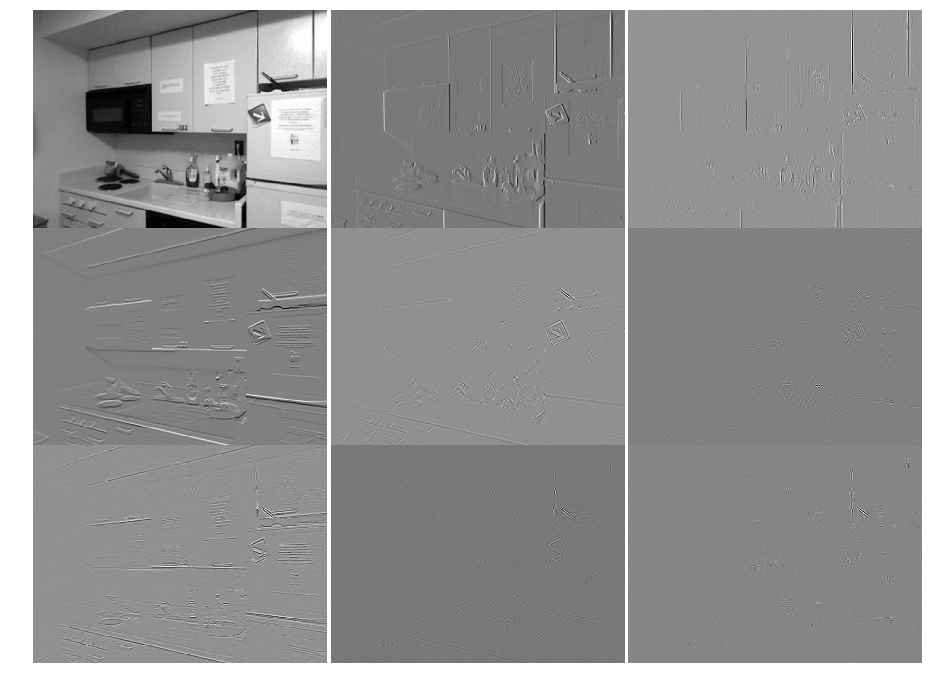

In [10]:
f, ax = plt.subplots(3, 3, figsize=(16, 12))
[x.set_axis_off() for x in ax.ravel()]
for i in range(9):
    filtered = sp.ndimage.filters.convolve(ycbcr[10:-10, 10:-10, 0], laws2d[i])
    filtered = (filtered - np.mean(filtered)) / np.std(filtered)
    ax[i // 3, i % 3].imshow(filtered, cmap='gray')
f.subplots_adjust(hspace=0.0, wspace=0.0)

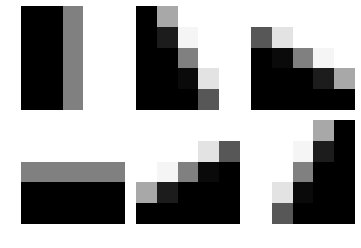

In [11]:
# Oriented edge filters from [Nevatia 1980]
NB0 = np.tile([-100, -100, 0, 100, 100], (5, 1)) / 2000
NB30 = np.array([
    [-100, 32, 100, 100, 100],
    [-100, -78, 92, 100, 100],
    [-100, -100, 0, 100, 100],
    [-100, -100, -92, 78, 100],
    [-100, -100, -100, -32, 100],
]) / 2000

NB60 = -NB30.T
NB90 = -NB0.T
NB120 = -np.flipud(NB60)
NB150 = NB120.T

NB = [NB0, NB30, NB60, NB90, NB120, NB150]

f, ax = plt.subplots(2, 3)
[x.set_axis_off() for x in ax.ravel()]
for i in range(6):
    ax[i // 3, i % 3].imshow(NB[i])
f.subplots_adjust(hspace=0.1, wspace=0.1)

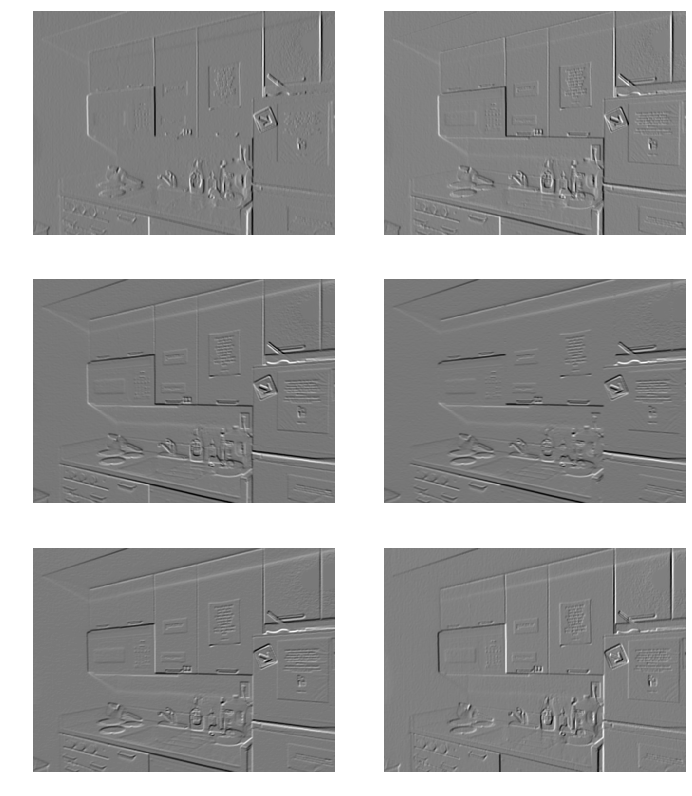

In [12]:
f, ax = plt.subplots(3, 2, figsize=(12, 14))
[x.set_axis_off() for x in ax.ravel()]
for i in range(6):
    filtered = sp.ndimage.filters.convolve(ycbcr[10:-10, 10:-10, 0], NB[i])
    filtered = (filtered - np.mean(filtered)) / np.std(filtered)
    ax[i // 2, i % 2].imshow(filtered, cmap='gray')
f.subplots_adjust(hspace=0.2, wspace=0.1)

In [14]:
def rescale(X):
    max_ = np.max(X)
    min_ = np.min(X)
    
    return (X - min_) / (max_ - min_)

def rescale_abs(X):
    return np.abs(rescale(X) - .5) # FIXME

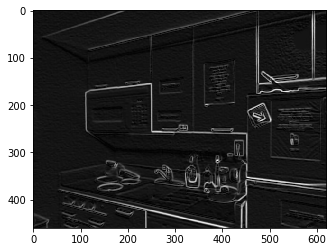

In [18]:
combined_edge = np.sum(rescale_abs(np.array([sp.ndimage.filters.convolve(ycbcr[10:-10, 10:-10, 0], NB[i]) for i in range(6)])), axis=0)
plt.imshow(combined_edge)

In [4]:
filters = laws2d + NB

Found nyu_depth_v2_labeled.mat
Found splits.mat


18

<Figure size 2880x1440 with 0 Axes>

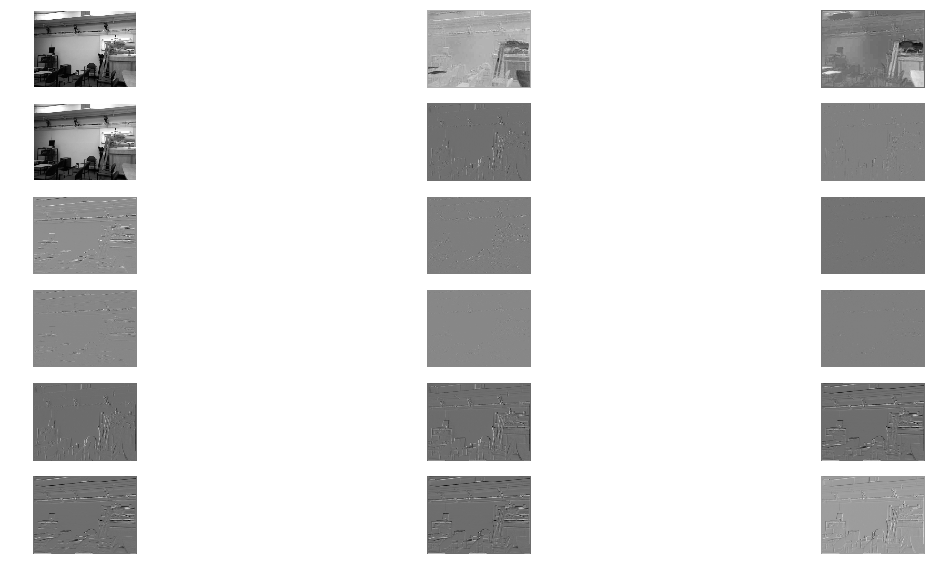

In [6]:
#asdf = sp.ndimage.filters.convolve(nyu['images'][train_indices[0]], L3L3)
#plt.imshow(asdf, cmap='gray')
data, splits = nyu.get_data()
train_indices = splits['trainNdxs'].flatten()
example = np.transpose(data['images'][train_indices[2]], (2, 1, 0))
ycbcr = skimage.color.rgb2ycbcr(example)

blurred = ycbcr[:, :, 0]
#blurred = sp.ndimage.filters.gaussian_filter(ycbcr[:, :, 0], 1)
feature_maps = [ycbcr[:, :, i] for i in range(3)]

plt.figure(figsize=(40, 20))
f, ax = plt.subplots(6, 3, figsize=(20, 10))
[x.set_axis_off() for x in ax.ravel()]
for i in range(len(filters)):
    fmap = sp.ndimage.filters.convolve(blurred, filters[i]) / 255.0
    feature_maps.append(fmap)
    
for i in range(len(feature_maps)):
    ax[i // 3, i % 3].imshow(feature_maps[i])

len(feature_maps)

(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)
(480, 640, 34)


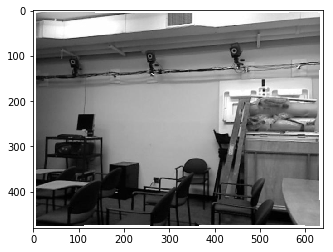

In [11]:
import features

fmaps = features.image_feature_maps(np.transpose(data['images'][train_indices[2]], (2, 1, 0)))
plt.imshow(fmaps[2][:, :, 0])

In [2]:
# Adapted from [Ma, Geng, Bie 2017] pure CNN network

import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Flatten, Input, MaxPooling2D, Reshape, UpSampling2D
from tensorflow.keras.models import Sequential
import loss

N_EPOCHS = 40
BATCH_SIZE = 1

train_ids, val_ids = nyu.train_validation_split(.05)
features = ['rgb', 'haralick16']
train_sequence = nyu.NyuSequence(train_ids, features=features, batch_size=4, dims=(320, 240), depth_scale=.25)
val_sequence = nyu.NyuSequence(val_ids, features=features, batch_size=1, dims=(320, 240), depth_scale=.25)

H, W, _ = train_sequence.data_shape()
N = np.float32(W * H)
def scale_invariant_loss(y_true, y_pred):
    #D = K.log(y_pred)
    #D_star = K.log(y_true)
    # THESE CAUSE NaNs!
    
    D = y_pred
    D_star = y_true
    d = D - D_star
    
    loss = (1 / N) * K.sum(K.pow(d, 2)) - (1 / K.pow(N, 2)) * K.pow(K.sum(d), 2)
    return loss

model = Sequential([
    Conv2D(50, 3, activation='relu', padding='same', input_shape=train_sequence.data_shape()),
    BatchNormalization(),
    Conv2D(50, 3, activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(50, 3, activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Conv2D(80, 3, activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Conv2D(80, 3, activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Conv2D(100, 3, activation='relu', padding='same'),
    UpSampling2D(size=(2, 2)),
    BatchNormalization(),
    Conv2D(120, 3, activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(1, 3, activation='linear', padding='same'),
])

model.compile(loss=loss.scale_invariant_gradient_loss(N), optimizer=tf.keras.optimizers.Adam())

Found nyu_depth_v2_labeled.mat
Found splits.mat
Found nyu_depth_v2_labeled.mat
Found splits.mat
Found nyu_depth_v2_labeled.mat
Found splits.mat
Instructions for updating:
Colocations handled automatically by placer.


In [3]:
model.summary()
cb = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)
model.fit_generator(train_sequence, epochs=300, verbose=1, validation_data=val_sequence, callbacks=[cb])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 240, 320, 50)      4100      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 240, 320, 50)      200       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 240, 320, 50)      22550     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 240, 320, 50)      200       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 240, 320, 50)      22550     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 120, 160, 50)      0         
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 120, 160, 50)      200       
__________

/usr/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


189/189 [==============================] - 49s 258ms/step - loss: 1.1477 - val_loss: 0.2406
Epoch 2/300
189/189 [==============================] - 46s 245ms/step - loss: 0.8537 - val_loss: 0.2264
Epoch 3/300
189/189 [==============================] - 46s 245ms/step - loss: 0.8343 - val_loss: 0.2469
Epoch 4/300
189/189 [==============================] - 46s 245ms/step - loss: 0.8119 - val_loss: 0.2306
Epoch 5/300
189/189 [==============================] - 45s 240ms/step - loss: 0.8146 - val_loss: 0.2353
Epoch 6/300
189/189 [==============================] - 46s 241ms/step - loss: 0.8027 - val_loss: 0.2194
Epoch 7/300
189/189 [==============================] - 46s 243ms/step - loss: 0.8012 - val_loss: 0.2143
Epoch 8/300
189/189 [==============================] - 46s 242ms/step - loss: 0.7891 - val_loss: 0.2156
Epoch 9/300
189/189 [==============================] - 45s 240ms/step - loss: 0.7939 - val_loss: 0.2196
Epoch 10/300
189/189 [==============================] - 46s 243ms/step - los

189/189 [==============================] - 46s 242ms/step - loss: 0.6113 - val_loss: 0.1983
Epoch 49/300
189/189 [==============================] - 45s 240ms/step - loss: 0.5995 - val_loss: 0.1922
Epoch 50/300
189/189 [==============================] - 45s 239ms/step - loss: 0.5966 - val_loss: 0.1942
Epoch 51/300
189/189 [==============================] - 46s 242ms/step - loss: 0.5885 - val_loss: 0.1973
Epoch 52/300
189/189 [==============================] - 47s 247ms/step - loss: 0.5832 - val_loss: 0.2007
Epoch 53/300
189/189 [==============================] - 47s 247ms/step - loss: 0.5707 - val_loss: 0.2079
Epoch 54/300
189/189 [==============================] - 45s 241ms/step - loss: 0.5663 - val_loss: 0.1968
Epoch 55/300
189/189 [==============================] - 46s 243ms/step - loss: 0.5554 - val_loss: 0.2006
Epoch 56/300
189/189 [==============================] - 46s 241ms/step - loss: 0.5538 - val_loss: 0.1989
Epoch 57/300
189/189 [==============================] - 46s 242ms/st

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


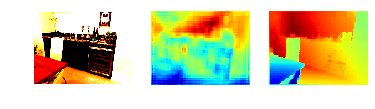

In [15]:
X, y = val_sequence[10]
img = X[0]
depth = y[0]
pred = model.predict(X)[0]

f, ax = plt.subplots(1, 3)
[x.set_axis_off() for x in ax.ravel()]
ax[0].imshow(img[:, :, :3])
ax[1].imshow(pred[:, :, 0], cmap='jet')
ax[2].imshow(depth[:, :, 0], cmap='jet')



In [28]:
import json
import os

name = 'fc_rgb_haralick16'
basedir = os.path.join('models', name)

# create model directory
if not os.path.exists(basedir):
    os.makedirs(basedir)

# save model
with open(os.path.join(basedir, 'model.json'), 'w') as json_file:
    json_file.write(model.to_json())

# serialize weights to HDF5
model.save_weights(os.path.join(basedir, 'weights.h5'))

# save history
with open(os.path.join(basedir, 'history.json'), 'w') as hist_file:
    json.dump(model.history.history, hist_file)

print('model saved')

model saved


In [16]:
_, splits = nyu.get_data()
test_ids = splits['testNdxs'].flatten()

Found nyu_depth_v2_labeled.mat
Found splits.mat


In [17]:
test_generator = nyu.NyuSequence(test_ids, features=features, batch_size=1, dims=(320, 240), depth_scale=.25)
model.evaluate_generator(test_generator, verbose=1)

Found nyu_depth_v2_labeled.mat
Found splits.mat
654/654 [==============================] - 51s 78ms/step - loss: 0.1674


0.16740603662389317

In [108]:
import loss
from tensorflow.keras.models import model_from_json
with open('models/fc_rgb/model.json', 'r') as f:
    rgb_json = f.read()
rgb_model = model_from_json(rgb_json)
test_generator = nyu.NyuSequence(test_ids, features=['rgb'], batch_size=1, dims=(320, 240), depth_scale=.25)
rgb_model.load_weights('models/fc_rgb/weights.h5')
rgb_model.compile(loss=loss.scale_invariant_gradient_loss(N), optimizer=tf.keras.optimizers.Adam())

loss_stats = np.zeros(len(test_generator))
for i in range(len(test_generator)):
    X, y = test_generator[i]
    loss_stats[i] = rgb_model.evaluate(x=X, y=y)

print('mean: ' + str(np.mean(loss_stats)))

Found nyu_depth_v2_labeled.mat
Found splits.mat
1/1 [==============================] - 0s 8ms/sample - loss: 0.2331


1/1 [==============================] - 0s 8ms/sample - loss: 0.1858


1/1 [==============================] - 0s 8ms/sample - loss: 0.2283


1/1 [==============================] - 0s 9ms/sample - loss: 0.0836


1/1 [==============================] - 0s 9ms/sample - loss: 0.1205


1/1 [==============================] - 0s 8ms/sample - loss: 0.2238
mean: 0.17762996269167836


In [25]:
import json
import nyu
import os

def calc_stats(model_name, features):
    _, splits = nyu.get_data()
    test_ids = splits['testNdxs'].flatten()
    base_dir = os.path.join('models', model_name)
    with open(os.path.join(base_dir, 'model.json'), 'r') as f:
        model_json = f.read()
    model = model_from_json(model_json)
    test_generator = nyu.NyuSequence(test_ids, features=features, dims=(320, 240), depth_scale=.25, shuffle=False)
    model.load_weights(os.path.join(base_dir, 'weights.h5'))
    model.compile(loss=loss.scale_invariant_gradient_loss(N), optimizer=tf.keras.optimizers.Adam())
    
    loss_stats = np.zeros(len(test_generator))
    for i in range(len(test_generator)):
        X, y = test_generator[i]
        loss_stats[i] = model.evaluate(x=X, y=y)
        
    stats = {
        'loss': loss_stats.tolist(),
        'mean': np.mean(loss_stats),
        'median': np.median(loss_stats),
        'stddev': np.std(loss_stats),
    }
    
    print(stats)
    with open(os.path.join(base_dir, 'stats.json'), 'w') as f:
        json.dump(stats, f)

In [130]:
calc_stats('fc_rgb', ['rgb'])

Found nyu_depth_v2_labeled.mat
Found splits.mat
Found nyu_depth_v2_labeled.mat
Found splits.mat
1/1 [==============================] - 0s 9ms/sample - loss: 0.1728


1/1 [==============================] - 0s 9ms/sample - loss: 0.1084


1/1 [==============================] - 0s 9ms/sample - loss: 0.2542


1/1 [==============================] - 0s 9ms/sample - loss: 0.0923


1/1 [==============================] - 0s 9ms/sample - loss: 0.1802


1/1 [==============================] - 0s 9ms/sample - loss: 0.2362
{'loss': [0.07247436791658401, 0.20995189249515533, 0.23333317041397095, 0.09371011704206467, 0.3306940197944641, 0.3525329828262329, 0.2387813776731491, 0.2311255782842636, 0.12482766062021255, 0.13323509693145752, 0.36356115341186523, 0.2128952294588089, 0.34892183542251587, 0.21855027973651886, 0.1894717514514923, 0.07114469259977341, 0.2638803720474243, 0.19575031101703644, 0.07580270618200302, 0.2130732536315918, 0.13667957484722137, 0.06416968256235123, 0.1450306475162506, 0.13120636343955994, 0.06903084367513657, 0.5143043994903564, 0.27204442024230957, 0.07027213275432587, 0.19357426464557648, 0.11892017722129822, 0.051253486424684525, 0.06320000439882278, 0.11687499284744263, 0.07028082758188248, 0.06193401664495468, 0.10230337083339691, 0.15574589371681213, 0.08240890502929688, 0.3603542447090149, 0.200014129281044, 0.2413879930973053, 0.39502036571502686, 0.7158201336860657, 0.3857805132865906, 0.49802070856

In [125]:
calc_stats('fc_rgb', ['rgb'])
calc_stats('fc_ycbcr', ['ycbcr'])
calc_stats('fc_rgb_ycbcr', ['rgb', 'ycbcr'])
calc_stats('fc_rgb_ycbcr_laws', ['rgb', 'ycbcr', 'laws'])
calc_stats('fc_rgb_ycbcr_laws_edge', ['rgb', 'ycbcr', 'laws', 'edge'])

Found nyu_depth_v2_labeled.mat
Found splits.mat
Found nyu_depth_v2_labeled.mat
Found splits.mat
1/1 [==============================] - 0s 9ms/sample - loss: 0.1359


1/1 [==============================] - 0s 9ms/sample - loss: 0.0825


1/1 [==============================] - 0s 9ms/sample - loss: 0.3201


1/1 [==============================] - 0s 9ms/sample - loss: 0.1680


1/1 [==============================] - 0s 9ms/sample - loss: 0.2046


1/1 [==============================] - 0s 9ms/sample - loss: 0.2249
{'loss': [0.06158692017197609, 0.22140654921531677, 0.25195610523223877, 0.06243658438324928, 0.2778635621070862, 0.3132776618003845, 0.21389256417751312, 0.22209620475769043, 0.14132097363471985, 0.14678189158439636, 0.3833383619785309, 0.2102278470993042, 0.3654972016811371, 0.23526844382286072, 0.15753737092018127, 0.06582529842853546, 0.2410915046930313, 0.18396887183189392, 0.0779864490032196, 0.18245083093643188, 0.14884492754936218, 0.054125696420669556, 0.1421619951725006, 0.08062256872653961, 0.059978023171424866, 0.42883843183517456, 0.2550815939903259, 0.08269088715314865, 0.18653811514377594, 0.11658990383148193, 0.06391017884016037, 0.082892045378685, 0.12214530259370804, 0.06547337770462036, 0.07145039737224579, 0.08722531050443649, 0.14119021594524384, 0.07794640213251114, 0.4158531129360199, 0.21465395390987396, 0.2273975908756256, 0.3920314610004425, 0.7508564591407776, 0.4052853286266327, 0.5094346404

Found nyu_depth_v2_labeled.mat
Found splits.mat
1/1 [==============================] - 0s 10ms/sample - loss: 0.1752


1/1 [==============================] - 0s 9ms/sample - loss: 0.0900


1/1 [==============================] - 0s 9ms/sample - loss: 0.1881


1/1 [==============================] - 0s 10ms/sample - loss: 0.0942


1/1 [==============================] - 0s 10ms/sample - loss: 0.2298


1/1 [==============================] - 0s 9ms/sample - loss: 0.2295
{'loss': [0.06614657491445541, 0.22187566757202148, 0.24093639850616455, 0.08406921476125717, 0.33565473556518555, 0.3490396738052368, 0.23319220542907715, 0.2632176876068115, 0.12778642773628235, 0.11887037754058838, 0.37585288286209106, 0.20866355299949646, 0.3457723557949066, 0.21035712957382202, 0.18064093589782715, 0.07525182515382767, 0.22739960253238678, 0.18011175096035004, 0.07923290133476257, 0.2119034230709076, 0.14537563920021057, 0.06644147634506226, 0.1213265210390091, 0.11444895714521408, 0.0794779360294342, 0.4873650372028351, 0.27150702476501465, 0.07837512344121933, 0.1906413733959198, 0.1249268501996994, 0.06234567239880562, 0.08647928386926651, 0.1399681568145752, 0.09549842774868011, 0.06571931391954422, 0.09741003811359406, 0.1800222098827362, 0.08230208605527878, 0.3929482400417328, 0.21393665671348572, 0.24066899716854095, 0.40826982259750366, 0.7793896794319153, 0.39170172810554504, 0.491275250

Found nyu_depth_v2_labeled.mat
Found splits.mat
1/1 [==============================] - 0s 12ms/sample - loss: 0.1354


1/1 [==============================] - 0s 12ms/sample - loss: 0.2125


1/1 [==============================] - 0s 12ms/sample - loss: 0.2683


1/1 [==============================] - 0s 12ms/sample - loss: 0.0421


1/1 [==============================] - 0s 12ms/sample - loss: 0.1190


1/1 [==============================] - 0s 12ms/sample - loss: 0.2434
{'loss': [0.052069179713726044, 0.1727878749370575, 0.23226577043533325, 0.06355519592761993, 0.2753816843032837, 0.32002413272857666, 0.21771523356437683, 0.21534624695777893, 0.10870475322008133, 0.11724385619163513, 0.38189777731895447, 0.21095451712608337, 0.3590407967567444, 0.21291065216064453, 0.14603616297245026, 0.06083688884973526, 0.24716296792030334, 0.19371601939201355, 0.07176437228918076, 0.1828904151916504, 0.11688132584095001, 0.04684347286820412, 0.12458682805299759, 0.09707363694906235, 0.05219697207212448, 0.44923123717308044, 0.23982855677604675, 0.07554049789905548, 0.1966988742351532, 0.1049538254737854, 0.062244221568107605, 0.07591258734464645, 0.11556178331375122, 0.06407485157251358, 0.05504109337925911, 0.07903853058815002, 0.13321468234062195, 0.055002741515636444, 0.3533472716808319, 0.2334418147802353, 0.23751118779182434, 0.40280643105506897, 0.7493200302124023, 0.398283988237381, 0.506

Found nyu_depth_v2_labeled.mat
Found splits.mat
1/1 [==============================] - 0s 13ms/sample - loss: 0.1334


1/1 [==============================] - 0s 13ms/sample - loss: 0.2096


1/1 [==============================] - 0s 13ms/sample - loss: 0.2733


1/1 [==============================] - 0s 13ms/sample - loss: 0.0493


1/1 [==============================] - 0s 13ms/sample - loss: 0.1157


1/1 [==============================] - 0s 13ms/sample - loss: 0.2134
{'loss': [0.07206860929727554, 0.22029557824134827, 0.2166796624660492, 0.0787031278014183, 0.29105353355407715, 0.26953405141830444, 0.23073551058769226, 0.22865507006645203, 0.11373044550418854, 0.11338838934898376, 0.37856900691986084, 0.2138594686985016, 0.33895277976989746, 0.21650749444961548, 0.15108074247837067, 0.06647469103336334, 0.23261725902557373, 0.17512762546539307, 0.08026126027107239, 0.20273761451244354, 0.1346435397863388, 0.049020033329725266, 0.10736305266618729, 0.13471442461013794, 0.06514796614646912, 0.4919441044330597, 0.2577781081199646, 0.05760104954242706, 0.15925996005535126, 0.10451345145702362, 0.05075754597783089, 0.0628565326333046, 0.11917562782764435, 0.0762256383895874, 0.053275395184755325, 0.09703730046749115, 0.1567029356956482, 0.0609453022480011, 0.32440513372421265, 0.20946137607097626, 0.2355566769838333, 0.37991073727607727, 0.755366325378418, 0.4147685766220093, 0.5096841

(array([ 3.,  4.,  7., 15., 17., 18., 26., 22., 25., 26., 31., 25., 16.,
        20., 23., 28., 23., 22., 20., 17., 24., 15., 15., 13., 13., 12.,
        20., 11., 12.,  4., 15.,  8.,  8.,  8.,  3.,  3.,  9.,  3.,  7.,
         4.,  1.,  4.,  3., 11.,  1.,  3.,  3.,  0.,  2.,  4.,  3.,  1.,
         1.,  1.,  1.,  1.,  0.,  2.,  2.,  1.,  0.,  4.,  0.,  1.,  0.,
         2.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.]),
 array([0.02226025, 0.02983155, 0.03740284, 0.04497414, 0.05254543,
        0.06011672, 0.06768802, 0.07525931, 0.08283061, 0.0904019 ,
        0.0979732 , 0.10554449, 0.11311578, 0.12068708, 0.12825837,
        0.13582967, 0.14340096, 0.15097225, 0.15854355, 0.16611484,
        0.17368614, 0.18125743, 0.18882873, 0.19640002, 0.20397131,
        0.21154261, 0.2191139 , 0.2266852 , 0.23425649, 0.24182779,
        0.24939908, 0.2569

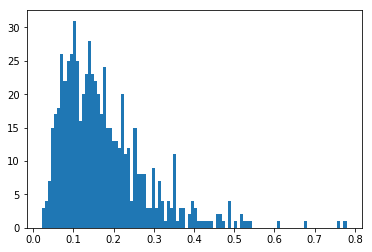

In [26]:
with open(os.path.join('keras', 'fc_rgb_ycbcr', 'stats.json')) as f:
    stats = json.load(f)
losses = np.array(stats['loss'])
plt.hist(losses, 100)

In [131]:
model_name = 'fc_rgb_ycbcr_laws_edge'
features = ['rgb', 'ycbcr', 'laws', 'edge']
_, splits = nyu.get_data()
test_ids = splits['testNdxs'].flatten()
base_dir = os.path.join('keras', model_name)
with open(os.path.join(base_dir, 'model.json'), 'r') as f:
    model_json = f.read()
model = model_from_json(model_json)
test_generator = nyu.NyuSequence(test_ids, features=features, dims=(320, 240), depth_scale=.25, shuffle=False)
model.load_weights(os.path.join(base_dir, 'weights.h5'))
model.compile(loss=loss.scale_invariant_gradient_loss(N), optimizer=tf.keras.optimizers.Adam())
with open(os.path.join(base_dir, 'stats.json'), 'r') as f:
    stats = json.load(f)
losses = stats['loss']
sorted_ids = np.argsort(losses)

Found nyu_depth_v2_labeled.mat
Found splits.mat
Found nyu_depth_v2_labeled.mat
Found splits.mat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


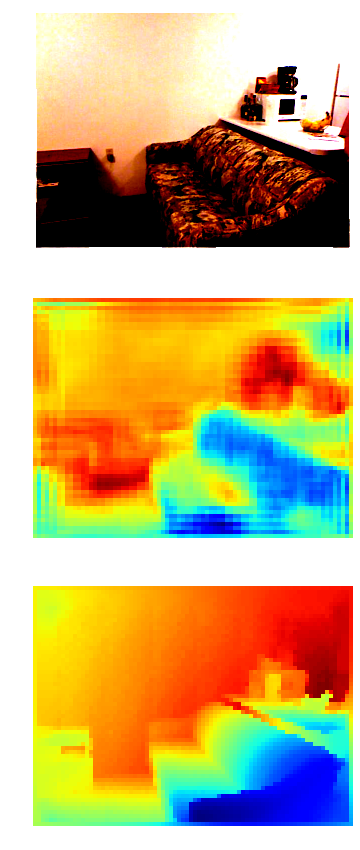

In [192]:
id_ = sorted_ids[21]
X, y_true = test_generator[id_]
y_pred = model.predict(X)
f, ax = plt.subplots(3, 1, figsize=(30, 15))
[x.set_axis_off() for x in ax]
ax[0].imshow(X[0, :, :, :3])
ax[1].imshow(rescale(y_pred[0, :, :, 0]), cmap='jet')
ax[2].imshow(rescale(y_true[0, :, :, 0]), cmap='jet')

In [1]:
import h5py
import features

f = h5py.File('nyuv2_glcms.h5', 'r')
map4x = features.patch_haralick(f['glcms_4x'][0])

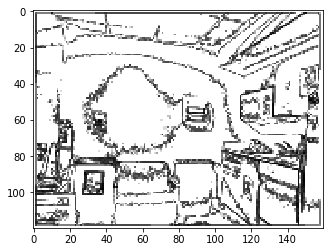

In [13]:
plt.imshow(rescale(map4x[:, :, 5]), cmap='gray')

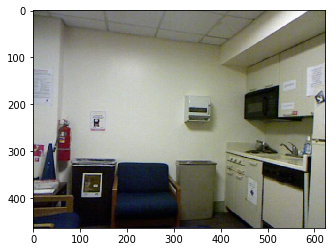

In [29]:
plt.imshow(img[8:-8, 8:-8])